In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import py3Dmol
import numpy as np
import csv
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from openbabel import openbabel
from openbabel import pybel
import re


from rdkit.Chem import Descriptors, Lipinski, Crippen, rdMolDescriptors
from rdkit.Chem import DataStructs
from mordred import Calculator, descriptors



import shutil
import subprocess
from multiprocessing import Pool, cpu_count
from glob import glob

# Molecule generation

In [78]:
# Imports csv as a dataframe
compound_smiles = pd.read_csv('compound_smiles.csv')
compound_smiles['compound'] = compound_smiles['compound'].astype(str)
compound_structures = compound_smiles.copy()
# Creates a new column called mol, and fills each row with the mol generated from the column smiles
compound_structures['mol'] = compound_structures['smiles'].apply(Chem.MolFromSmiles)
# prints the new df
compound_structures

,compound,smiles,mol
0,Paracetamol,OC1=CC=C(NC(C)=O)C=C1,<rdkit.Chem.rdchem.Mol object at 0x17bf62ce0>


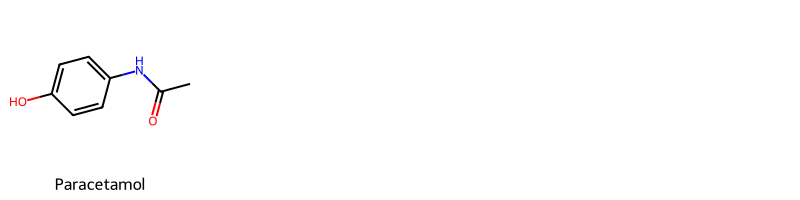

In [51]:
# Make lists of the rdkit objects and the name
mols = list(compound_structures['mol'])
name = list(compound_structures['compound'])
# rdkit prints an image of each compound
img = Draw.MolsToGridImage(
    mols,
    subImgSize=(200, 200),  
    legends=name,
    molsPerRow=4
)
display(img)

In [107]:
# Convert molecule to a 3D structure and adding implicit hydrogens
def mol2D_to_mol3D(mol):
    mol3D = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol3D)
    AllChem.MMFFOptimizeMolecule(mol3D)
    return mol3D
compound_structures['mol3D'] = compound_structures['mol'].apply(mol2D_to_mol3D)

In [ ]:
# Direct 3D molecule from SMILES (with MMFF force field optimisation)
compound_structures = compound_smiles.copy() 
def smiles_to_mol3d(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol3D = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol3D)
    AllChem.MMFFOptimizeMolecule(mol3D)
    return mol, mol3D

compound_structures[['2Dmol','3Dmol']] = compound_structures['smiles'].apply(smiles_to_mol3d).apply(pd.Series)

In [ ]:
# PyMol visualiation of 3D structure
def show_3D_molecule(index, df):
    mol = df.loc[index, '3Dmol']
    if mol is None:
        print(f"No molecule found at index {index}")
        return
    mol_block = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=800, height=400)
    viewer.addModel(mol_block, "mol")
    viewer.setStyle({'stick': {}})
    viewer.zoomTo()
    return viewer.show()
show_3D_molecule(0,compound_structures)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Descriptor generation

In [118]:
# RDKit properties
def calculate_rdkit_properties(mol):
    properties = {}
    # Basic properties
    properties['MolWt'] = Descriptors.MolWt(mol)
    properties['LogP'] = Descriptors.MolLogP(mol)
    properties['NumHDonors'] = Descriptors.NumHDonors(mol)
    properties['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
    properties['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
    properties['NumAromaticRings'] = Descriptors.NumAromaticRings(mol)
    properties['TPSA'] = Descriptors.TPSA(mol)
    properties['NumHeavyAtoms'] = Descriptors.HeavyAtomCount(mol)
    
    return properties

In [113]:
# Mordred descriptor calculation
def calculate_mordred_descriptors(mol):
    # Create calculator with all descriptors
    calc = Calculator(descriptors, ignore_3D=False)
    result = calc(mol)
    
    # Convert to dictionary, handling any calculation errors
    mordred_dict = {}
    for i, desc in enumerate(calc.descriptors):
        try:
            value = result[i]
            if not isinstance(value, (int, float, np.number)):
                value = None
            mordred_dict[str(desc)] = value
        except:
            mordred_dict[str(desc)] = None
    
    return mordred_dict

In [114]:
# Example function for fingerprint generation
def generate_fingerprints(mol):
    """Generate various molecular fingerprints"""
    fingerprints = {}
    
    # Morgan fingerprints (ECFP-like)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fingerprints['morgan_fp'] = morgan_fp
    
    # MACCS keys
    maccs_fp = AllChem.GetMACCSKeysFingerprint(mol)
    fingerprints['maccs_fp'] = maccs_fp
    
    # RDKit fingerprint
    rdkit_fp = Chem.RDKFingerprint(mol)
    fingerprints['rdkit_fp'] = rdkit_fp
    
    # Atom pair fingerprint
    atompair_fp = AllChem.GetAtomPairFingerprint(mol)
    fingerprints['atompair_fp'] = atompair_fp
    
    # Topological torsion fingerprint
    torsion_fp = AllChem.GetTopologicalTorsionFingerprint(mol)
    fingerprints['torsion_fp'] = torsion_fp
    
    return fingerprints

# Convert fingerprints to numpy arrays for ML
def fp_to_array(fp):
    """Convert fingerprint to numpy array"""
    arr = np.zeros((len(fp),))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [ ]:
# Process a single molecule
mol = compound_structures.iloc[0]['mol3D']
props = calculate_rdkit_properties(mol)
mordred = calculate_mordred_descriptors(mol)
fps = generate_fingerprints(mol)
morgan_fp_array = fp_to_array(fps['morgan_fp'])

[12:03:58] DEPRECATION WARNING: please use MorganGenerator
[12:03:58] DEPRECATION WARNING: please use AtomPairGenerator
[12:03:58] DEPRECATION WARNING: please use TopologicalTorsionGenerator


In [128]:
# Automated processing of molecules in dataframe
def process_molecules(compound_structures):
    #Process all molecules in the dataframe
    
    # Initialize lists to store results
    rdkit_props_list = []
    mordred_desc_list = []
    morgan_arrays = []
    maccs_arrays = []
    
    # Loop through molecules
    for idx, row in compound_structures.iterrows():
        mol = row['mol3D']
        
        if mol is not None:
            print(f"Processing molecule {idx}...")
            
            # Calculate RDKit properties
            try:
                rdkit_props = calculate_rdkit_properties(mol)
                rdkit_props_list.append(rdkit_props)
            except Exception as e:
                print(f"Error calculating RDKit properties for molecule {idx}: {e}")
                rdkit_props_list.append({})
            
            # Calculate Mordred descriptors (can be slow for large molecules)
            try:
                mordred_desc = calculate_mordred_descriptors(mol)
                mordred_desc_list.append(mordred_desc)
            except Exception as e:
                print(f"Error calculating Mordred descriptors for molecule {idx}: {e}")
                mordred_desc_list.append({})
            
            # Generate fingerprints
            try:
                fps = generate_fingerprints(mol)
                
                # Convert to arrays for ML
                morgan_arrays.append(fp_to_array(fps['morgan_fp']))
                maccs_arrays.append(fp_to_array(fps['maccs_fp']))
            except Exception as e:
                print(f"Error generating fingerprints for molecule {idx}: {e}")
                morgan_arrays.append(None)
                maccs_arrays.append(None)
        else:
            # Handle None molecules
            rdkit_props_list.append({})
            mordred_desc_list.append({})
            morgan_arrays.append(None)
            maccs_arrays.append(None)
    
    # Create DataFrames from results
    rdkit_df = pd.DataFrame(rdkit_props_list)
    mordred_df = pd.DataFrame(mordred_desc_list)
    
    # Add fingerprint arrays to compound_structures
    compound_structures['morgan_fp'] = morgan_arrays
    compound_structures['maccs_fp'] = maccs_arrays
    
    return rdkit_df, mordred_df


In [132]:
rdkit, mordred = process_molecules(compound_structures)

Processing molecule 0...


[12:11:45] DEPRECATION WARNING: please use MorganGenerator
[12:11:45] DEPRECATION WARNING: please use AtomPairGenerator
[12:11:45] DEPRECATION WARNING: please use TopologicalTorsionGenerator


In [135]:
compound_structures

,compound,smiles,mol,mol3D,morgan_fp,maccs_fp
0,Paracetamol,OC1=CC=C(NC(C)=O)C=C1,<rdkit.Chem.rdchem.Mol object at 0x17bf62ce0>,<rdkit.Chem.rdchem.Mol object at 0x17f126180>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Exporting molecules

In [ ]:
# Exporting molecules to XYZ coordinate file
def mol_to_xyz(mol, name):
    file_name = name
    output_filename = f"{file_name}.xyz"
    Chem.MolToXYZFile(mol, output_filename)

mols = list(compound_structures['3Dmol'])
names = list(compound_structures['compound'])

for mol, name in zip(mols, names):  
    mol_to_xyz(mol, name)

In [ ]:
# Exporting molecules to mol file
def mol_to_xyz(mol, name):
    file_name = name
    output_filename = f"{file_name}.mol"
    Chem.MolToMolFile(mol, output_filename)

mols = list(compound_structures['3Dmol'])
names = list(compound_structures['compound'])

for mol, name in zip(mols, names):  
    mol_to_xyz(mol, name)

# Gaussian 

In [ ]:
# Need to define the dft keywords in dft_opt_keywords.txt

# Makes a list of xyz files within specified directory
current_location = os.getcwd() # Calls pathname for the directory this notebook is saved in
path_of_the_directory = current_location 

ext = ('.xyz')
xyz_files_list=[]
for files in os.listdir(path_of_the_directory):
    if files.endswith(ext):
        xyz_files_list=xyz_files_list+[files]
xyz_files_list

['Paracetamol.xyz']

In [ ]:
def xyz_to_dft_opt(xyz_file):
    with open(xyz_file, 'r') as f:
        xyz_content = f.read()

        # Convert to molecular structure
        xyz = pybel.readstring("xyz", xyz_content)

        gjf_file=xyz_file[:xyz_file.rfind(".")]+".gjf"

        # Save the molecular structure to mol file
        xyz.write("gjf", gjf_file,overwrite=True,opt={"b":"yes","f":"dft_opt_keywords.txt"})
    
    elements=[]
    with open(gjf_file, "r") as file:
        lines = file.readlines()
        count=0
        title_line_index=0
        for i in range(len(lines)):
            if lines[i].split()==[]:
                count+=1
            if count==1:
                title_line_index=i+2
            if count==4:
                elements=elements+re.findall(r"[a-zA-Z]+", lines[i+3])

    unique_letters = set()
    # Iterate over each letter in the list
    for element in elements:
    # Add the letter to the set if it's not already present
        if element not in unique_letters:
            unique_letters.add(element)
                
    lines[title_line_index]=gjf_file[:gjf_file.rfind(".")]
    lines.insert(title_line_index+1, "\n")
    lines[2]="%chk="+gjf_file[:gjf_file.rfind(".")]+"_opt.chk\n"

# Change the script below to change basis sets
    with open(gjf_file, "w") as file:
        file.writelines(lines)
        file.write("\n")
        file.write(" ".join(list(unique_letters))+" 0" "\n")
        file.write("6-31G(d)\n")

        
    
    return print(gjf_file+' converted ')

In [104]:
for compound in xyz_files_list:
    xyz_to_dft_opt(compound)

Paracetamol.gjf converted 


In [105]:
# Added gen features to define basis sets for metals

def xyz_to_dft_opt_metal(xyz_file):
    with open(xyz_file, 'r') as f:
        xyz_content = f.read()

        # Convert to molecular structure
        xyz = pybel.readstring("xyz", xyz_content)

        gjf_file=xyz_file[:xyz_file.rfind(".")]+".gjf"

        # Save the molecular structure to mol file
        xyz.write("gjf", gjf_file,overwrite=True,opt={"b":"yes","f":"dft_opt_keywords.txt"})
    
    elements=[]
    with open(gjf_file, "r") as file:
        lines = file.readlines()
        count=0
        title_line_index=0
        for i in range(len(lines)):
            if lines[i].split()==[]:
                count+=1
            if count==1:
                title_line_index=i+2
            if count==4:
                elements=elements+re.findall(r"[a-zA-Z]+", lines[i+3])

    unique_letters = set()
    # Iterate over each letter in the list
    for element in elements:
    # Add the letter to the set if it's not already present
        if element not in unique_letters:
            unique_letters.add(element)
                
    lines[title_line_index]=gjf_file[:gjf_file.rfind(".")]
    lines.insert(title_line_index+1, "\n")
    lines[2]="%chk="+gjf_file[:gjf_file.rfind(".")]+"_opt.chk\n"
    
    # Add desired basis sets and metals below
    with open(gjf_file, "w") as file:
        file.writelines(lines)
        file.write("\n")
        file.write(" ".join(list(unique_letters))+" 0" "\n")
        file.write("6-31G(d)\n")
        file.write("****\n")
        file.write("Pt 0\n")
        file.write("LANL2DZ\n")
        file.write("****\n")
        file.write("\n")
        file.write("Pt 0\n")
        file.write("LANL2DZ\n")
        file.write("\n")
        file.write("\n")
        file.write("\n")
        
    
    return print(gjf_file+' converted ')

You can use .gjf files generated using GaussView as a guide on how to edit the script above. Use the text view of the .gjf file to see required input structure.

# xTB

Install xTB using:

conda install -y -c conda-forge xtb=6.7.1

conda install conda-forge::libgfortran=14.2.0


In [142]:
import os, shutil, subprocess

OUTPUT_DIR = "molecule_xtb_opt"

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def run_xtb_on_xyz(xyz_path, workdir, opt_xyz_name, log_name):
    xyz_name = os.path.basename(xyz_path)
    shutil.copy(xyz_path, os.path.join(workdir, xyz_name))
    
    cmd = f"xtb '{xyz_name}' --opt --gfn 2 --pop"
    log_path = os.path.join(workdir, log_name)

    with open(log_path, "w") as log:
        result = subprocess.run(cmd, shell=True, cwd=workdir,
                                stdout=log, stderr=subprocess.STDOUT)

    xtbopt = os.path.join(workdir, "xtbopt.xyz")
    if os.path.exists(xtbopt):
        shutil.move(xtbopt, os.path.join(workdir, opt_xyz_name))
    return result.returncode

def xtb_process_xyz_file(xyz_file):
    mol_name = os.path.splitext(os.path.basename(xyz_file))[0]
    mol_dir = os.path.join(OUTPUT_DIR, mol_name)
    ensure_dir(mol_dir)

    opt_xyz = os.path.join(mol_dir, f"opt_{mol_name}.xyz")
    if os.path.exists(opt_xyz):
        print(f"[{mol_name}] Skipping, already optimized.")
        return

    print(f"[{mol_name}] Running xTB optimization...")
    log_name = f"xtb_{mol_name}.log"
    ret = run_xtb_on_xyz(xyz_file, mol_dir, f"opt_{mol_name}.xyz", log_name)

    msg = "completed successfully" if ret == 0 else "failed"
    print(f"[{mol_name}] xTB optimization {msg}")

# --- Run all files ---
ensure_dir(OUTPUT_DIR)
print(f"Processing {len(xyz_files_list)} XYZ files...")

for xyz in xyz_files_list:
    if os.path.exists(xyz):
        xtb_process_xyz_file(xyz)
    else:
        print(f"Warning: XYZ file not found: {xyz}")


Processing 1 XYZ files...
[Paracetamol] Skipping, already optimized.


In [145]:
# Extracting QM properties from the log file
import re

def extract_properties_from_log(log_path):
    """Extract all QM properties from an xTB log file."""
    props = {}

    # --- Read the log file ---
    try:
        with open(log_path, "r") as f:
            out = f.read()
    except Exception as e:
        print(f"Could not read {log_path}: {e}")
        return props

    try:
        # === Dipole moments ===
        dipole_matches = re.findall(
            r"(q only|full):\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)(?:\s+([-\d.]+))?", out
        )
        for label, x, y, z, tot in dipole_matches:
            label_key = label.replace(" ", "").replace("+", "plus")
            props[f"dipole_{label_key}_x"] = float(x)
            props[f"dipole_{label_key}_y"] = float(y)
            props[f"dipole_{label_key}_z"] = float(z)
            if tot:
                props[f"dipole_{label_key}_total"] = float(tot)

        # === Quadrupole tensors ===
        quad_matches = re.findall(
            r"(q only|q\+dip|full):\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)", out
        )
        for label, xx, xy, yy, xz, yz, zz in quad_matches:
            label_key = label.replace(" ", "").replace("+", "plus")
            props[f"quad_{label_key}_xx"] = float(xx)
            props[f"quad_{label_key}_xy"] = float(xy)
            props[f"quad_{label_key}_yy"] = float(yy)
            props[f"quad_{label_key}_xz"] = float(xz)
            props[f"quad_{label_key}_yz"] = float(yz)
            props[f"quad_{label_key}_zz"] = float(zz)

        # === Geometry summary ===
        com_match = re.search(r"center of mass at/Å\s*:\s*([-\d.eE]+)\s+([-\d.eE]+)\s+([-\d.eE]+)", out)
        moi_match = re.search(
            r"moments of inertia/u·Å²\s*:\s*([-\d.eE+]+)\s+([-\d.eE+]+)\s+([-\d.eE+]+)",
            out, re.IGNORECASE
        )
        rot_match = re.search(r"rotational constants/cm⁻¹\s*:\s*([-\d.eE]+)\s+([-\d.eE]+)\s+([-\d.eE]+)", out)

        if com_match:
            props["center_of_mass_x"] = float(com_match.group(1))
            props["center_of_mass_y"] = float(com_match.group(2))
            props["center_of_mass_z"] = float(com_match.group(3))

        if moi_match:
            props["moment_inertia_xx"] = float(moi_match.group(1))
            props["moment_inertia_yy"] = float(moi_match.group(2))
            props["moment_inertia_zz"] = float(moi_match.group(3))

        if rot_match:
            props["rot_const_x"] = float(rot_match.group(1))
            props["rot_const_y"] = float(rot_match.group(2))
            props["rot_const_z"] = float(rot_match.group(3))

        # === Energies ===
        total_energy = re.search(r"total energy\s*:\s*([-\d.]+)\s*Eh", out)
        grad_norm = re.search(r"gradient norm\s*:\s*([-\d.]+)\s*Eh/α", out)
        gap_ev = re.search(r"HOMO-LUMO gap\s*:\s*([-\d.]+)\s*eV", out)

        if total_energy:
            props["total_energy"] = float(total_energy.group(1))
        if grad_norm:
            props["gradient_norm"] = float(grad_norm.group(1))
        if gap_ev:
            props["homo_lumo_gap_ev"] = float(gap_ev.group(1))

        # === Fermi level ===
        fermi = re.search(r"Fermi-level[^\n]*?\s+([-\d.]+)\s+eV", out)
        if fermi:
            props["fermi_level_ev"] = float(fermi.group(1))

        # === HOMO and LUMO energies ===
        homo_ev = re.search(r"\(HOMO\).*?([-\d.]+)", out)
        lumo_ev = re.search(r"\(LUMO\).*?([-\d.]+)", out)
        if homo_ev:
            props["homo_energy_ev"] = float(homo_ev.group(1))
        if lumo_ev:
            props["lumo_energy_ev"] = float(lumo_ev.group(1))

        # === Summary block ===
        summary_patterns = {
            "total_energy_eh": r"total energy\s+([-\d.]+)\s+Eh",
            "gradient_norm": r"gradient norm\s+([-\d.]+)\s+Eh/a0",
            "homo_lumo_gap_ev": r"HOMO-LUMO gap\s+([-\d.]+)\s+eV",
            "scc_energy": r"SCC energy\s+([-\d.]+)\s+Eh",
            "isotropic_es": r"isotropic ES\s+([-\d.]+)\s+Eh",
            "anisotropic_es": r"anisotropic ES\s+([-\d.]+)\s+Eh",
            "anisotropic_xc": r"anisotropic XC\s+([-\d.]+)\s+Eh",
            "dispersion_energy": r"dispersion\s+([-\d.]+)\s+Eh",
            "repulsion_energy": r"repulsion energy\s+([-\d.]+)\s+Eh",
            "additional_restraining": r"add\. restraining\s+([-\d.]+)\s+Eh",
            "total_charge": r"total charge\s+([-\d.]+)\s+e"
        }

        for key, pattern in summary_patterns.items():
            match = re.search(pattern, out)
            if match:
                props[key] = float(match.group(1))

        # === HOMO/LUMO table values ===
        homo_lumo_match = re.findall(
            r"^\s*\d+\s+[\d\.]*\s+[-\d\.]+\s+([-]?\d+\.\d+)\s+\(HOMO\)|"
            r"^\s*\d+\s+[\d\.]*\s+[-\d\.]+\s+([-]?\d+\.\d+)\s+\(LUMO\)",
            out, re.MULTILINE
        )
        homo_energy = None
        lumo_energy = None
        for homo_val, lumo_val in homo_lumo_match:
            if homo_val:
                homo_energy = float(homo_val)
            if lumo_val:
                lumo_energy = float(lumo_val)
        if homo_energy is not None:
            props["homo_energy_eV"] = homo_energy
        if lumo_energy is not None:
            props["lumo_energy_eV"] = lumo_energy

    except Exception as e:
        print(f"Error extracting from {log_path}: {e}")

    return props


In [ ]:
results = []

for xyz_file in xyz_files_list:
    mol_name = os.path.splitext(os.path.basename(xyz_file))[0]
    mol_dir = os.path.join(OUTPUT_DIR, mol_name)
    log_path = os.path.join(mol_dir, f"xtb_{mol_name}.log")

    if os.path.exists(log_path):
        props = extract_properties_from_log(log_path)
        props["name"] = mol_name
        results.append(props)
    else:
        print(f"[Warning] Log not found for {mol_name}")

# Convert all results to a DataFrame
xtb_results_df = pd.DataFrame(results)
xtb_results_df.head()


,dipole_qonly_x,dipole_qonly_y,dipole_qonly_z,dipole_full_x,dipole_full_y,dipole_full_z,dipole_full_total,dipole_qonly_total,quad_qonly_xx,quad_qonly_xy,...,isotropic_es,anisotropic_es,anisotropic_xc,dispersion_energy,repulsion_energy,additional_restraining,total_charge,homo_energy_eV,lumo_energy_eV,name
0,4.628,-3.429,-3.165,5.153,-2.607,-3.904,-0.211,-0.693,4.628,-3.429,...,0.058129,0.004664,0.010534,-0.015935,0.438872,0.0,-0.0,-10.0856,-6.3304,Paracetamol
